In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import talib
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['Heiti TC'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

In [40]:
T2306_df = pd.read_csv('/Users/tuxun/work/jnwork/建模大赛/HFtrading/data/bond/future.csv')
B220220_df = pd.read_csv('/Users/tuxun/work/jnwork/建模大赛/HFtrading/data/bond/lobs.csv')

T2306_df['ts'] = T2306_df['ts'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
T2306_df.index = pd.to_datetime(T2306_df['ts'])
T2306_df['midprice'] = (T2306_df['ask1'] + T2306_df['bid1']) / 2
T2306_df = T2306_df[~T2306_df.index.duplicated()]

B220220_df['ts'] = B220220_df['ts'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000))
B220220_df.index = pd.to_datetime(B220220_df['ts'])
B220220_df['midprice'] = (B220220_df['pask1'] + B220220_df['pbid1']) / 2
B220220_df['ymidprice'] = (B220220_df['yask1'] + B220220_df['ybid1']) / 2
B220220_df['yspread'] = B220220_df['ybid1'] - B220220_df['yask1']
B220220_df['pspread'] = B220220_df['pask1'] - B220220_df['pbid1']
B220220_df = B220220_df[~B220220_df.index.duplicated()]


start_time = '2023-03-23 9:30:00'
end_time = '2023-04-18 15:15:00'
T2306_df = T2306_df.loc[start_time: end_time]
B220220_df = B220220_df.loc[start_time: end_time]

T2306_df = T2306_df.between_time('9:30', '11:30').append(T2306_df.between_time('13:30', '15:15'))
B220220_df = B220220_df.between_time('9:30', '11:30').append(B220220_df.between_time('13:30', '15:15'))

T2306_df.sort_index(inplace=True)  
B220220_df.sort_index(inplace=True)

In [27]:
def filter_index(df, time_diff):
    selected_index = []
    prev_index = None

    for index, row in df.iterrows():
        if prev_index is None:
            selected_index.append(index)
            prev_index = index
        else:
            diff = (index - prev_index).total_seconds()
            if diff >= time_diff:
                selected_index.append(index)
                prev_index = index
            else:
                continue
    return df.loc[selected_index]

In [32]:
def pAlpha(x):
    low = min(x)
    high = max(x)
    close = x[-1]
    if high > low:
        return (close - low) / (high - low)
    else:
        return 0.5

In [33]:
def stepSig(x):
    sig_len = len(x)
    before = x[-sig_len:-sig_len//2]
    after = x[-sig_len//2:]
    b = min(after) - max(before)
    s = min(before) - max(after)
    if b >= 0.0049:
        return x[-1] - x[0]
    elif s >= 0.0049:
        return x[-1] - x[0]
    else:  
        return 0

In [54]:
def cal_result(T, B, sig_len, after_n, sig_func = None, state = 'normal'):

    T_alldays = None
    n = 0

    for oneday in T['ts'].apply(lambda x: x.date()).unique():
        t_oneday = T.loc[oneday.strftime('%Y-%m-%d')]
        if sig_func == 'RSI':
            t_oneday['order_sig'] = talib.RSI(T['midprice'], timeperiod = sig_len)
        else:
            t_oneday['order_sig'] = t_oneday['midprice'].rolling(sig_len).apply(sig_func)
        if n == 0:
            T_alldays = t_oneday
            n = 1
        else:
            T_alldays = T_alldays.append(t_oneday)

    before_filter_number = len(T_alldays)   
    if state != 'equal':
        if sig_func == 'RSI':
            T_alldays = T_alldays.loc[(T_alldays['order_sig'] < 30) | (T_alldays['order_sig'] > 70)]
        elif sig_func == pAlpha:
            T_alldays = T_alldays.loc[(T_alldays['order_sig'] < 0.1) | (T_alldays['order_sig'] > 0.9)]
        elif sig_func == stepSig:
            T_alldays = T_alldays.loc[T_alldays['order_sig'] != 0]
    else:
        if sig_func == 'RSI':
            T_alldays = T_alldays.loc[(T_alldays['order_sig'] >= 30) & (T_alldays['order_sig'] <= 70)]
        elif sig_func == pAlpha:
            T_alldays = T_alldays.loc[(T_alldays['order_sig'] >= 0.1) & (T_alldays['order_sig'] <= 0.9)]
        elif sig_func == stepSig:
            T_alldays = T_alldays.loc[T_alldays['order_sig'] == 0]

    T_alldays = filter_index(T_alldays, after_n)
    after_filter_number = len(T_alldays)
    
    if state == 'normal':
        if sig_func == 'RSI':
            B_buy_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] > 70].index.to_list(), method='nearest')]
            B_buy_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] > 70].index + pd.Timedelta(seconds=after_n), method='nearest')]

            B_sell_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] < 30].index.to_list(), method='nearest')]
            B_sell_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] < 30].index + pd.Timedelta(seconds=after_n), method='nearest')]
        elif sig_func == pAlpha:
            B_buy_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0.9].index.to_list(), method='nearest')]
            B_buy_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0.9].index + pd.Timedelta(seconds=after_n), method='nearest')]

            B_sell_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0.1].index.to_list(), method='nearest')]
            B_sell_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0.1].index + pd.Timedelta(seconds=after_n), method='nearest')]
        elif sig_func == stepSig:
            B_buy_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0].index.to_list(), method='nearest')]
            B_buy_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0].index + pd.Timedelta(seconds=after_n), method='nearest')]

            B_sell_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0].index.to_list(), method='nearest')]
            B_sell_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0].index + pd.Timedelta(seconds=after_n), method='nearest')]
    elif state == 'equal':
        if sig_func == 'RSI':
            B_buy_points = B.iloc[B.index.get_indexer(T_alldays[(T_alldays['order_sig'] >=30) & (T_alldays['order_sig'] <= 70)].index.to_list(), method='nearest')]
            B_buy_points_after = B.iloc[B.index.get_indexer(T_alldays[(T_alldays['order_sig'] >= 30) & (T_alldays['order_sig'] <= 70)].index + pd.Timedelta(seconds=after_n), method='nearest')]
            B_sell_points = []
            B_sell_points_after = []
        elif sig_func == pAlpha:
            B_buy_points = B.iloc[B.index.get_indexer(T_alldays[(T_alldays['order_sig'] >=0.1) & (T_alldays['order_sig'] <= 0.9)].index.to_list(), method='nearest')]
            B_buy_points_after = B.iloc[B.index.get_indexer(T_alldays[(T_alldays['order_sig'] >= 0.1) & (T_alldays['order_sig'] <= 0.9)].index + pd.Timedelta(seconds=after_n), method='nearest')]
            B_sell_points = []
            B_sell_points_after = []
        elif sig_func == stepSig:
            B_buy_points = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] == 0].index.to_list(), method='nearest')]
            B_buy_points_after = B.iloc[B.index.get_indexer(T_alldays[T_alldays['order_sig'] == 0].index + pd.Timedelta(seconds=after_n), method='nearest')]
            B_sell_points = []
            B_sell_points_after = []
    elif state == 'self':
        if sig_func == 'RSI':
            B_buy_points = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] > 70].index.to_list(), method='nearest')]
            B_buy_points_after = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] > 70].index + pd.Timedelta(seconds=after_n), method='nearest')]

            B_sell_points = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] < 30].index.to_list(), method='nearest')]
            B_sell_points_after = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] < 30].index + pd.Timedelta(seconds=after_n), method='nearest')]
        elif sig_func == pAlpha:
            B_buy_points = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0.9].index.to_list(), method='nearest')]
            B_buy_points_after = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0.9].index + pd.Timedelta(seconds=after_n), method='nearest')]

            B_sell_points = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0.1].index.to_list(), method='nearest')]
            B_sell_points_after = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0.1].index + pd.Timedelta(seconds=after_n), method='nearest')]
        elif sig_func == stepSig:
            B_buy_points = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0].index.to_list(), method='nearest')]
            B_buy_points_after = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] > 0].index + pd.Timedelta(seconds=after_n), method='nearest')]

            B_sell_points = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0].index.to_list(), method='nearest')]
            B_sell_points_after = T.iloc[T.index.get_indexer(T_alldays[T_alldays['order_sig'] < 0].index + pd.Timedelta(seconds=after_n), method='nearest')]     


    Buy_point_number = len(B_buy_points) + len(B_sell_points)
    
    if state == 'self':
        buy_price_delta = B_buy_points_after['midprice'].reset_index() - B_buy_points['midprice'].reset_index()
        buy_price_delta = buy_price_delta['midprice']
    
        sell_price_delta = B_sell_points['midprice'].reset_index() - B_sell_points_after['midprice'].reset_index()
        sell_price_delta = sell_price_delta['midprice']  
    elif state == 'equal':
        buy_price_delta = B_buy_points_after['ymidprice'].reset_index() - B_buy_points['ymidprice'].reset_index()
        buy_price_delta = buy_price_delta['ymidprice']
        sell_price_delta = None
    elif state == 'normal':
        buy_price_delta = B_buy_points_after['ymidprice'].reset_index() - B_buy_points['ymidprice'].reset_index()
        buy_price_delta = buy_price_delta['ymidprice']
    
        sell_price_delta = B_sell_points['ymidprice'].reset_index() - B_sell_points_after['ymidprice'].reset_index()
        sell_price_delta = sell_price_delta['ymidprice']          
    
    
    price_delta = buy_price_delta.append(sell_price_delta)
    q_low = price_delta.quantile(0.01)
    q_high = price_delta.quantile(0.99)
    df_filtered = price_delta[(price_delta >= q_low) & (price_delta <= q_high)]
    df_mean = df_filtered.mean()
    df_sum = df_filtered.sum()
    win_rate = df_filtered[df_filtered > 0].count() / df_filtered.count()
    loss_rate = df_filtered[df_filtered < 0].count() / df_filtered.count()
    return df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number



In [58]:
result = []
result_equal = []
result_self = []
for sig_len in [5,10, 20, 40, 60, 100]:
    for after_n in range(10, 70, 10):
        print('sig_len: ', sig_len, 'after_n: ', after_n)
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, 'RSI', 'normal')
        result.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, 'RSI', 'equal')
        result_equal.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, 'RSI', 'self')
        result_self.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])

rsi_result = pd.DataFrame(result, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])
rsi_result_equal = pd.DataFrame(result_equal, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])
rsi_result_self = pd.DataFrame(result_self, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])



sig_len:  5 after_n:  10
sig_len:  5 after_n:  20
sig_len:  5 after_n:  30
sig_len:  5 after_n:  40
sig_len:  5 after_n:  50
sig_len:  5 after_n:  60
sig_len:  10 after_n:  10
sig_len:  10 after_n:  20
sig_len:  10 after_n:  30
sig_len:  10 after_n:  40
sig_len:  10 after_n:  50
sig_len:  10 after_n:  60
sig_len:  20 after_n:  10
sig_len:  20 after_n:  20
sig_len:  20 after_n:  30
sig_len:  20 after_n:  40
sig_len:  20 after_n:  50
sig_len:  20 after_n:  60
sig_len:  40 after_n:  10
sig_len:  40 after_n:  20
sig_len:  40 after_n:  30
sig_len:  40 after_n:  40
sig_len:  40 after_n:  50
sig_len:  40 after_n:  60
sig_len:  60 after_n:  10
sig_len:  60 after_n:  20
sig_len:  60 after_n:  30
sig_len:  60 after_n:  40
sig_len:  60 after_n:  50
sig_len:  60 after_n:  60
sig_len:  100 after_n:  10
sig_len:  100 after_n:  20
sig_len:  100 after_n:  30
sig_len:  100 after_n:  40
sig_len:  100 after_n:  50
sig_len:  100 after_n:  60


In [59]:

result = []
result_equal = []
result_self = []
for sig_len in [5,10, 20, 40, 60, 100]:
    for after_n in range(10, 70, 10):
        print('sig_len: ', sig_len, 'after_n: ', after_n)
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, pAlpha, 'normal')
        result.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, pAlpha, 'equal')
        result_equal.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, pAlpha, 'self')
        result_self.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])

pAlpha_result = pd.DataFrame(result, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])
pAlpha_result_equal = pd.DataFrame(result_equal, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])
pAlpha_result_self = pd.DataFrame(result_self, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])


sig_len:  5 after_n:  10
sig_len:  5 after_n:  20
sig_len:  5 after_n:  30
sig_len:  5 after_n:  40
sig_len:  5 after_n:  50
sig_len:  5 after_n:  60
sig_len:  10 after_n:  10
sig_len:  10 after_n:  20
sig_len:  10 after_n:  30
sig_len:  10 after_n:  40
sig_len:  10 after_n:  50
sig_len:  10 after_n:  60
sig_len:  20 after_n:  10
sig_len:  20 after_n:  20
sig_len:  20 after_n:  30
sig_len:  20 after_n:  40
sig_len:  20 after_n:  50
sig_len:  20 after_n:  60
sig_len:  40 after_n:  10
sig_len:  40 after_n:  20
sig_len:  40 after_n:  30
sig_len:  40 after_n:  40
sig_len:  40 after_n:  50
sig_len:  40 after_n:  60
sig_len:  60 after_n:  10
sig_len:  60 after_n:  20
sig_len:  60 after_n:  30
sig_len:  60 after_n:  40
sig_len:  60 after_n:  50
sig_len:  60 after_n:  60
sig_len:  100 after_n:  10
sig_len:  100 after_n:  20
sig_len:  100 after_n:  30
sig_len:  100 after_n:  40
sig_len:  100 after_n:  50
sig_len:  100 after_n:  60


In [46]:
pAlpha_result

sig_len  after_n      mean  win_rate  loss_rate      sum  \
0         5       10  0.000654  0.634759   0.248132  5.07385   
1         5       20  0.000913  0.651256   0.260284  5.01495   
2         5       30  0.000996  0.643705   0.273679  4.28095   
3         5       40  0.001048  0.640415   0.284193  3.74055   
4         5       50  0.001108  0.636156   0.295114  3.40155   
5         5       60  0.001065  0.610679   0.318873  2.87175   
6        10       10  0.000581  0.610501   0.267915  5.39925   
7        10       20  0.000865  0.644253   0.264823  5.22300   
8        10       30  0.000951  0.636109   0.281061  4.40765   
9        10       40  0.001011  0.636580   0.287939  3.82970   
10       10       50  0.001082  0.627699   0.297964  3.50870   
11       10       60  0.001102  0.610698   0.320581  3.11165   
12       20       10  0.000441  0.567698   0.297122  6.11205   
13       20       20  0.000683  0.605784   0.298332  5.24445   
14       20       30  0.000782  0.606288   0.310912  4.27955   
15       20       40  0.000858  0.603476   0.320046  3.70365   
16       20       50  0.000907  0.595046   0.332869  3.25815   
17       20       60  0.000869  0.583279   0.342515  2.68050   
18       40       10  0.000342  0.532940   0.320068  5.85710   
19       40       20  0.000475  0.557310   0.336721  4.39025   
20       40       30  0.000549  0.555157   0.357276  3.52070   
21       40       40  0.000596  0.558568   0.358487  2.94505   
22       40       50  0.000622  0.556578   0.365581  2.50155   
23       40       60  0.000662  0.551237   0.373969  2.24905   
24       60       10  0.000319  0.525889   0.325264  5.50360   
25       60       20  0.000469  0.552859   0.341318  4.40895   
26       60       30  0.000500  0.544606   0.368171  3.26835   
27       60       40  0.000536  0.545310   0.372019  2.69540   
28       60       50  0.000529  0.540891   0.381734  2.15855   
29       60       60  0.000558  0.533507   0.393125  1.93120   
30      100       10  0.000322  0.529267   0.324594  4.95435   
31      100       20  0.000472  0.554867   0.343578  4.04035   
32      100       30  0.000517  0.548424   0.366111  3.13405   
33      100       40  0.000567  0.551658   0.369685  2.66665   
34      100       50  0.000552  0.538640   0.385888  2.13710   
35      100       60  0.000561  0.537971   0.389733  1.84520   

    before_filter_number  after_filter_number  Buy_point_number  
0                 219667                 7921              7921  
1                 219667                 5608              5608  
2                 219667                 4385              4385  
3                 219667                 3642              3642  
4                 219667                 3134              3134  
5                 219667                 2753              2753  
6                 219667                 9483              9483  
7                 219667                 6159              6159  
8                 219667                 4732              4732  
9                 219667                 3866              3866  
10                219667                 3310              3310  
11                219667                 2881              2881  
12                219667                14146             14146  
13                219667                 7832              7832  
14                219667                 5583              5583  
15                219667                 4405              4405  
16                219667                 3667              3667  
17                219667                 3150              3150  
18                219667                17481             17481  
19                219667                 9437              9437  
20                219667                 6549              6549  
21                219667                 5045              5045  
22                219667                 4105              4105  
23                219667                 3466      

In [60]:

result = []
result_equal = []
result_self = []
for sig_len in [4,6, 8, 10, 12, 24]:
    for after_n in range(10, 70, 10):
        print('sig_len: ', sig_len, 'after_n: ', after_n)
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, stepSig, 'normal')
        result.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, stepSig, 'equal')
        result_equal.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])
        df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number = cal_result(T2306_df, B220220_df, sig_len, after_n, stepSig, 'self')
        result_self.append([sig_len, after_n, df_mean, win_rate, loss_rate, df_sum, before_filter_number, after_filter_number, Buy_point_number])

stepsig_result = pd.DataFrame(result, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])
stepsigresult_equal = pd.DataFrame(result_equal, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])
stepsig_result_self = pd.DataFrame(result_self, columns=['sig_len', 'after_n', 'mean', 'win_rate', 'loss_rate', 'sum', 'before_filter_number', 'after_filter_number', 'Buy_point_number'])


sig_len:  4 after_n:  10
sig_len:  4 after_n:  20
sig_len:  4 after_n:  30
sig_len:  4 after_n:  40
sig_len:  4 after_n:  50
sig_len:  4 after_n:  60
sig_len:  6 after_n:  10
sig_len:  6 after_n:  20
sig_len:  6 after_n:  30
sig_len:  6 after_n:  40
sig_len:  6 after_n:  50
sig_len:  6 after_n:  60
sig_len:  8 after_n:  10
sig_len:  8 after_n:  20
sig_len:  8 after_n:  30
sig_len:  8 after_n:  40
sig_len:  8 after_n:  50
sig_len:  8 after_n:  60
sig_len:  10 after_n:  10
sig_len:  10 after_n:  20
sig_len:  10 after_n:  30
sig_len:  10 after_n:  40
sig_len:  10 after_n:  50
sig_len:  10 after_n:  60
sig_len:  12 after_n:  10
sig_len:  12 after_n:  20
sig_len:  12 after_n:  30
sig_len:  12 after_n:  40
sig_len:  12 after_n:  50
sig_len:  12 after_n:  60
sig_len:  24 after_n:  10
sig_len:  24 after_n:  20
sig_len:  24 after_n:  30
sig_len:  24 after_n:  40
sig_len:  24 after_n:  50
sig_len:  24 after_n:  60


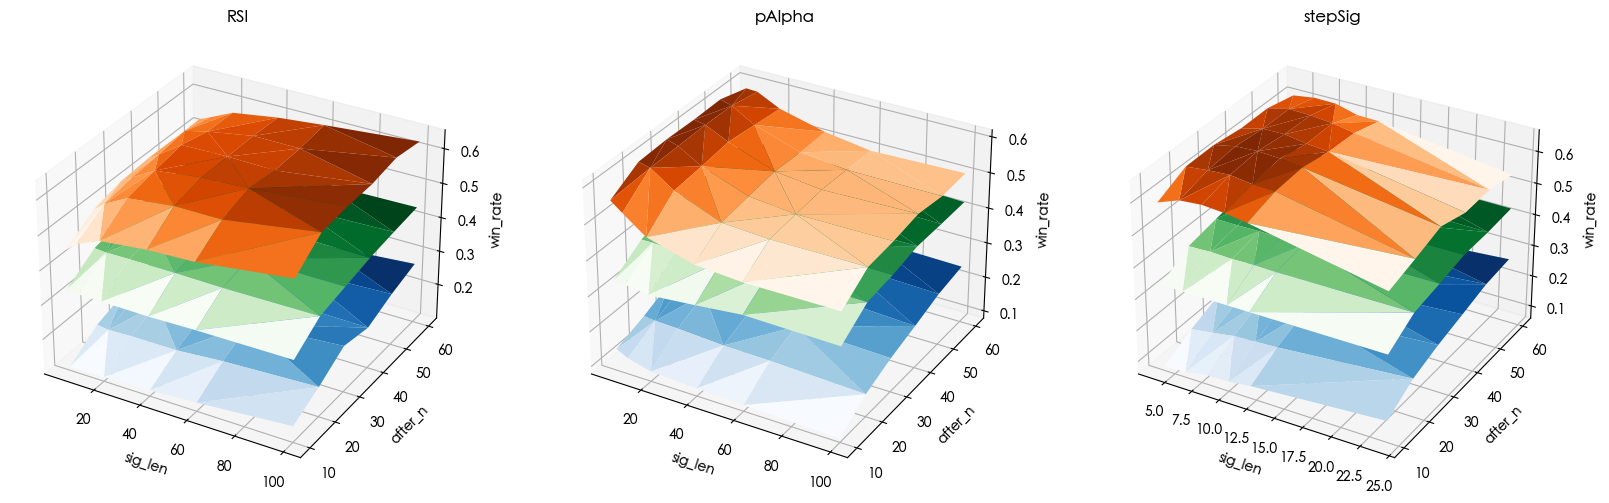

In [62]:
#把三个曲面图都画出来, 且给每个曲面加上标题
fig = plt.figure(figsize=(20, 10))
#fig.suptitle('有信号，无信号，期货自身的胜率')
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

#把三个曲面图的标题分别设置为'loss_rate', 'win_rate', 'mean'
ax1.set_title('RSI')
ax2.set_title('pAlpha')
ax3.set_title('stepSig')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.set_xlabel('sig_len')
ax1.set_ylabel('after_n')
ax1.set_zlabel('win_rate')


#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.set_xlabel('sig_len')
ax2.set_ylabel('after_n')
ax2.set_zlabel('win_rate')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.set_xlabel('sig_len')
ax3.set_ylabel('after_n')
ax3.set_zlabel('win_rate')

ax1.plot_trisurf(rsi_result['sig_len'], rsi_result['after_n'], rsi_result['loss_rate'], cmap='Oranges')
ax1.plot_trisurf(rsi_result_equal['sig_len'], rsi_result_equal['after_n'], rsi_result_equal['loss_rate'], cmap='Greens')
ax1.plot_trisurf(rsi_result_self['sig_len'], rsi_result_self['after_n'], rsi_result_self['win_rate'], cmap='Blues')

ax2.plot_trisurf(pAlpha_result['sig_len'], pAlpha_result['after_n'], pAlpha_result['loss_rate'], cmap='Oranges')
ax2.plot_trisurf(pAlpha_result_equal['sig_len'], pAlpha_result_equal['after_n'], pAlpha_result_equal['loss_rate'], cmap='Greens')
ax2.plot_trisurf(pAlpha_result_self['sig_len'], pAlpha_result_self['after_n'], pAlpha_result_self['win_rate'], cmap='Blues')

ax3.plot_trisurf(stepsig_result['sig_len'], stepsig_result['after_n'], stepsig_result['loss_rate'], cmap='Oranges')
ax3.plot_trisurf(stepsigresult_equal['sig_len'], stepsigresult_equal['after_n'], stepsigresult_equal['loss_rate'], cmap='Greens')
ax3.plot_trisurf(stepsig_result_self['sig_len'], stepsig_result_self['after_n'], stepsig_result_self['win_rate'], cmap='Blues')

plt.show()

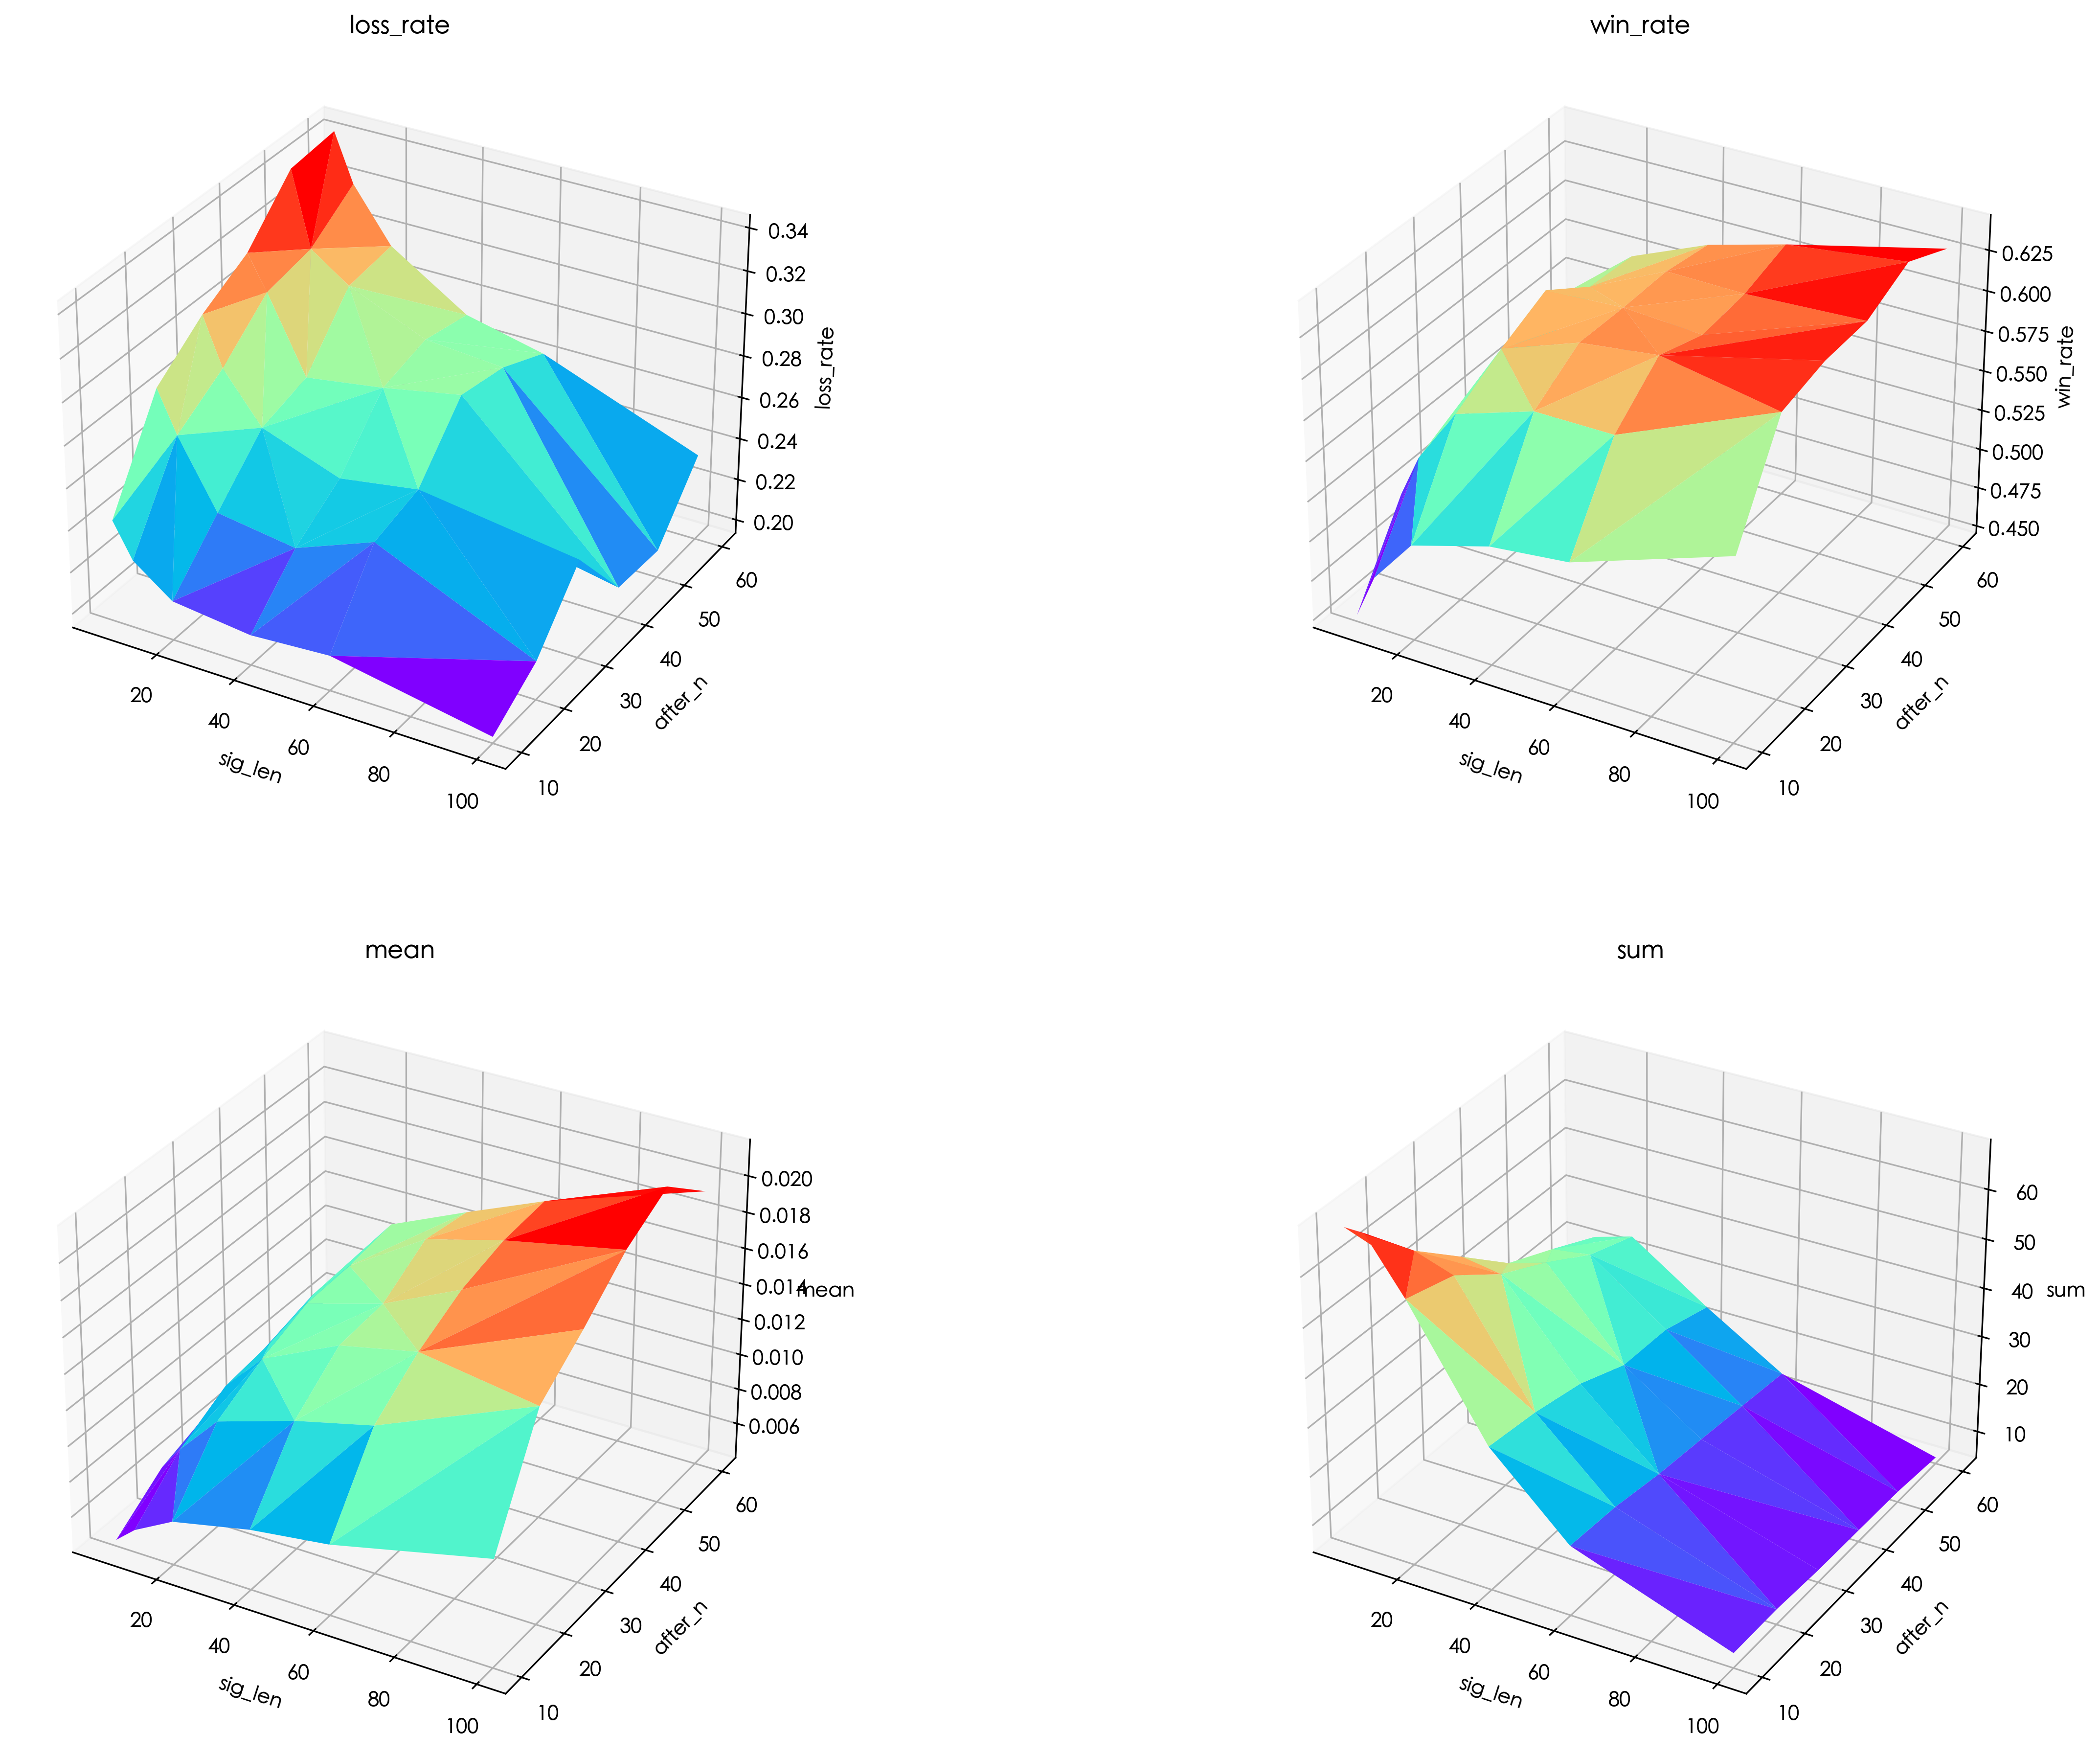

In [67]:
#把三个曲面图都画出来, 且给每个曲面加上标题
fig = plt.figure(figsize=(20, 15), dpi=300)
#标题居中
#fig.suptitle('RSI指标的参数搜索', ha='center')
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

#把三个曲面图的标题分别设置为'loss_rate', 'win_rate', 'mean'
ax1.set_title('loss_rate')
ax2.set_title('win_rate')
ax3.set_title('mean')
ax4.set_title('sum')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.set_xlabel('sig_len')
ax1.set_ylabel('after_n')
ax1.set_zlabel('loss_rate')


#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.set_xlabel('sig_len')
ax2.set_ylabel('after_n')
ax2.set_zlabel('win_rate')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.set_xlabel('sig_len')
ax3.set_ylabel('after_n')
ax3.set_zlabel('mean')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'sum'
ax4.set_xlabel('sig_len')
ax4.set_ylabel('after_n')
ax4.set_zlabel('sum')

rsi_result['mean'] = rsi_result['mean'] / 100
rsi_result['sum'] = rsi_result['sum'] / 100


#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.plot_trisurf(rsi_result['sig_len'], rsi_result['after_n'], rsi_result['win_rate'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.plot_trisurf(rsi_result['sig_len'], rsi_result['after_n'], rsi_result['loss_rate'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.plot_trisurf(rsi_result['sig_len'], rsi_result['after_n'], rsi_result['mean'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'sum'
ax4.plot_trisurf(rsi_result['sig_len'], rsi_result['after_n'], rsi_result['sum'], cmap='rainbow')

#plt.subplots_adjust(left = 0.35, right = 0.75, top = 0.8, bottom = 0.3,  wspace=0.1, hspace=0.1)
#让图中间的空白小一点
#plt.subplots_adjust(left = 0.2, right = 0.8, top = 0.9, bottom = 0.1,  wspace=0.1, hspace=0.1)

plt.show()

In [68]:
#找出mean最大的行
print('平均值最大的行')
print(rsi_result[rsi_result['mean'] == rsi_result['mean'].max()])

#找出win_rate最大的行
print('胜率最大的行')
print(rsi_result[rsi_result['loss_rate'] == rsi_result['loss_rate'].max()])

#找出sum最大的行
print('总和最大的行')
print(rsi_result[rsi_result['sum'] == rsi_result['sum'].max()])

平均值最大的行
    sig_len  after_n      mean  win_rate  loss_rate    sum  \
34      100       50  0.021623  0.206557   0.642623  6.595   

    before_filter_number  after_filter_number  Buy_point_number  
34                219667                  313               313  
胜率最大的行
    sig_len  after_n      mean  win_rate  loss_rate    sum  \
34      100       50  0.021623  0.206557   0.642623  6.595   

    before_filter_number  after_filter_number  Buy_point_number  
34                219667                  313               313  
总和最大的行
   sig_len  after_n      mean  win_rate  loss_rate    sum  \
0        5       10  0.004358  0.242189    0.44939  68.63   

   before_filter_number  after_filter_number  Buy_point_number  
0                219667                16041             16041  


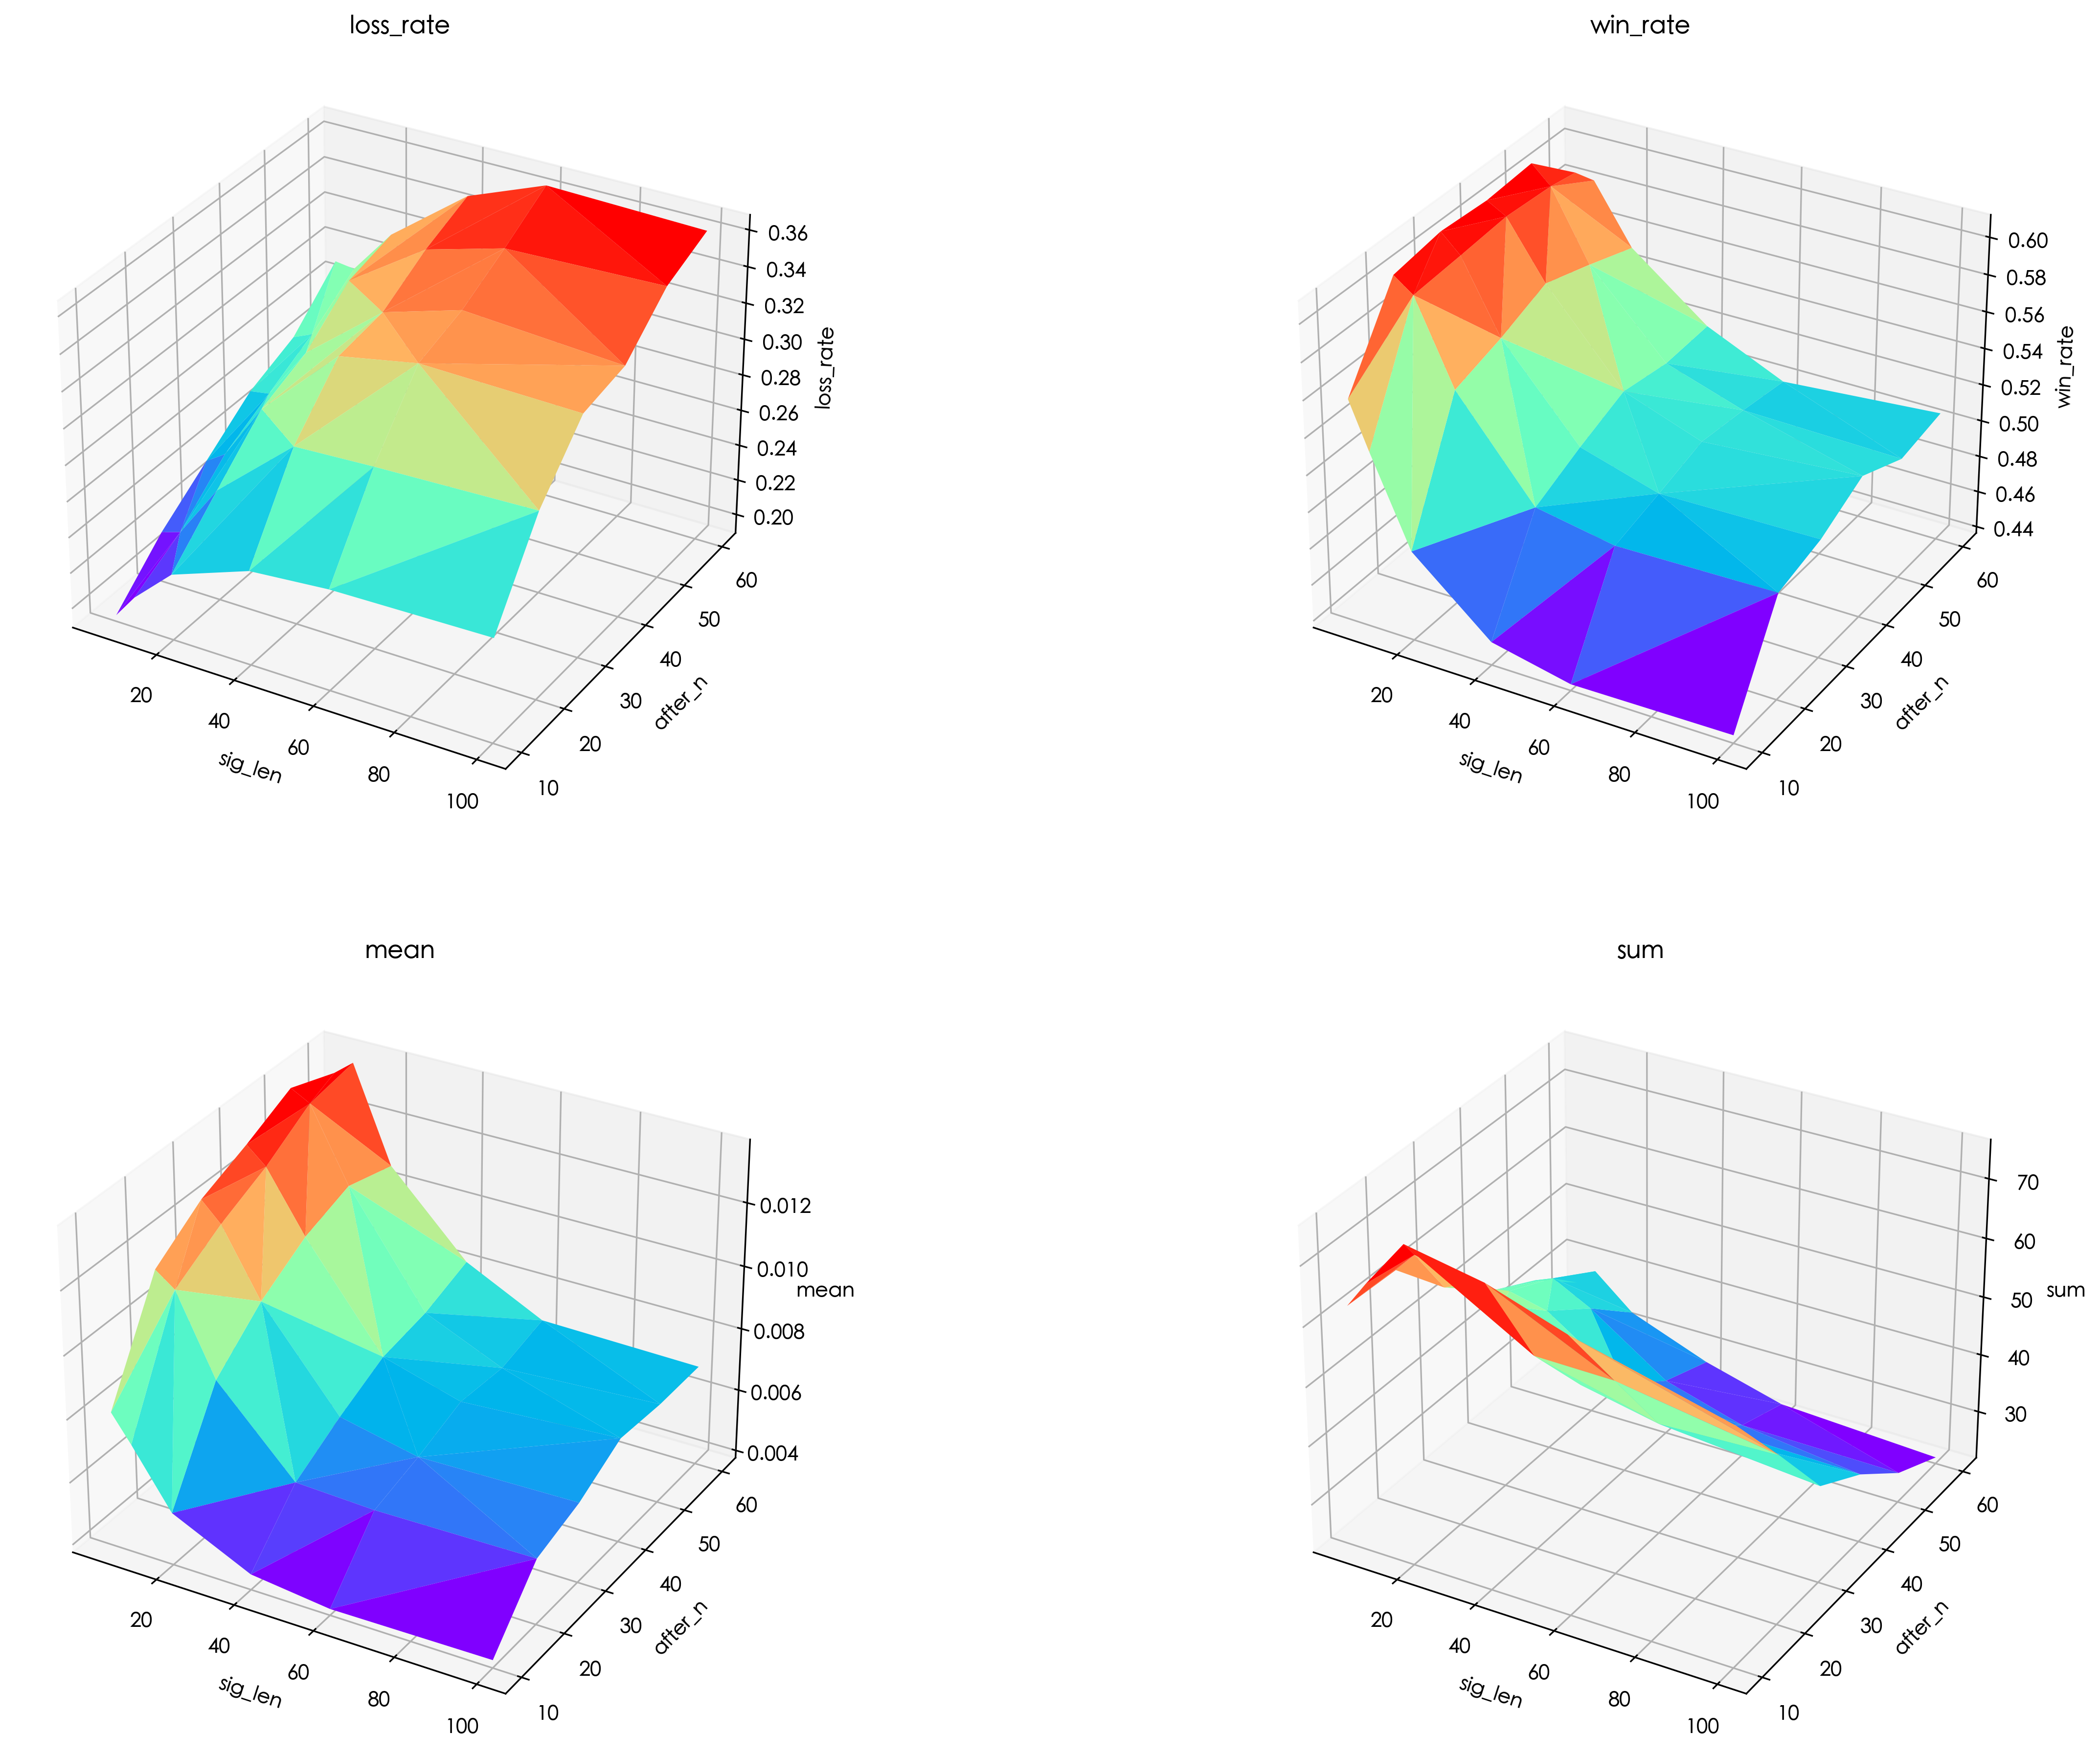

In [69]:
#把三个曲面图都画出来, 且给每个曲面加上标题
fig = plt.figure(figsize=(20, 15), dpi=300)
#标题居中
#fig.suptitle('RSI指标的参数搜索', ha='center')
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

#把三个曲面图的标题分别设置为'loss_rate', 'win_rate', 'mean'
ax1.set_title('loss_rate')
ax2.set_title('win_rate')
ax3.set_title('mean')
ax4.set_title('sum')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.set_xlabel('sig_len')
ax1.set_ylabel('after_n')
ax1.set_zlabel('loss_rate')


#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.set_xlabel('sig_len')
ax2.set_ylabel('after_n')
ax2.set_zlabel('win_rate')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.set_xlabel('sig_len')
ax3.set_ylabel('after_n')
ax3.set_zlabel('mean')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'sum'
ax4.set_xlabel('sig_len')
ax4.set_ylabel('after_n')
ax4.set_zlabel('sum')

pAlpha_result['mean'] = pAlpha_result['mean'] * -100
pAlpha_result['sum'] = pAlpha_result['sum'] * -100

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.plot_trisurf(pAlpha_result['sig_len'], pAlpha_result['after_n'], pAlpha_result['win_rate'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.plot_trisurf(pAlpha_result['sig_len'], pAlpha_result['after_n'], pAlpha_result['loss_rate'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.plot_trisurf(pAlpha_result['sig_len'], pAlpha_result['after_n'], pAlpha_result['mean'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'sum'
ax4.plot_trisurf(pAlpha_result['sig_len'], pAlpha_result['after_n'], pAlpha_result['sum'], cmap='rainbow')

#plt.subplots_adjust(left = 0.35, right = 0.75, top = 0.8, bottom = 0.3,  wspace=0.1, hspace=0.1)
#让图中间的空白小一点
#plt.subplots_adjust(left = 0.2, right = 0.8, top = 0.9, bottom = 0.1,  wspace=0.1, hspace=0.1)

plt.show()

In [70]:
#找出mean最大的行
print('平均值最大的行')
print(pAlpha_result[pAlpha_result['mean'] == pAlpha_result['mean'].max()])

#找出win_rate最大的行
print('胜率最大的行')
print(pAlpha_result[pAlpha_result['loss_rate'] == pAlpha_result['loss_rate'].max()])

#找出sum最大的行
print('总和最大的行')
print(pAlpha_result[pAlpha_result['sum'] == pAlpha_result['sum'].max()])

平均值最大的行
   sig_len  after_n      mean  win_rate  loss_rate    sum  \
4        5       50  0.013759  0.266775   0.608469  42.24   

   before_filter_number  after_filter_number  Buy_point_number  
4                219667                 3134              3134  
胜率最大的行
   sig_len  after_n      mean  win_rate  loss_rate    sum  \
4        5       50  0.013759  0.266775   0.608469  42.24   

   before_filter_number  after_filter_number  Buy_point_number  
4                219667                 3134              3134  
总和最大的行
    sig_len  after_n      mean  win_rate  loss_rate    sum  \
12       20       10  0.005426  0.226131   0.485359  75.42   

    before_filter_number  after_filter_number  Buy_point_number  
12                219667                14146             14146  


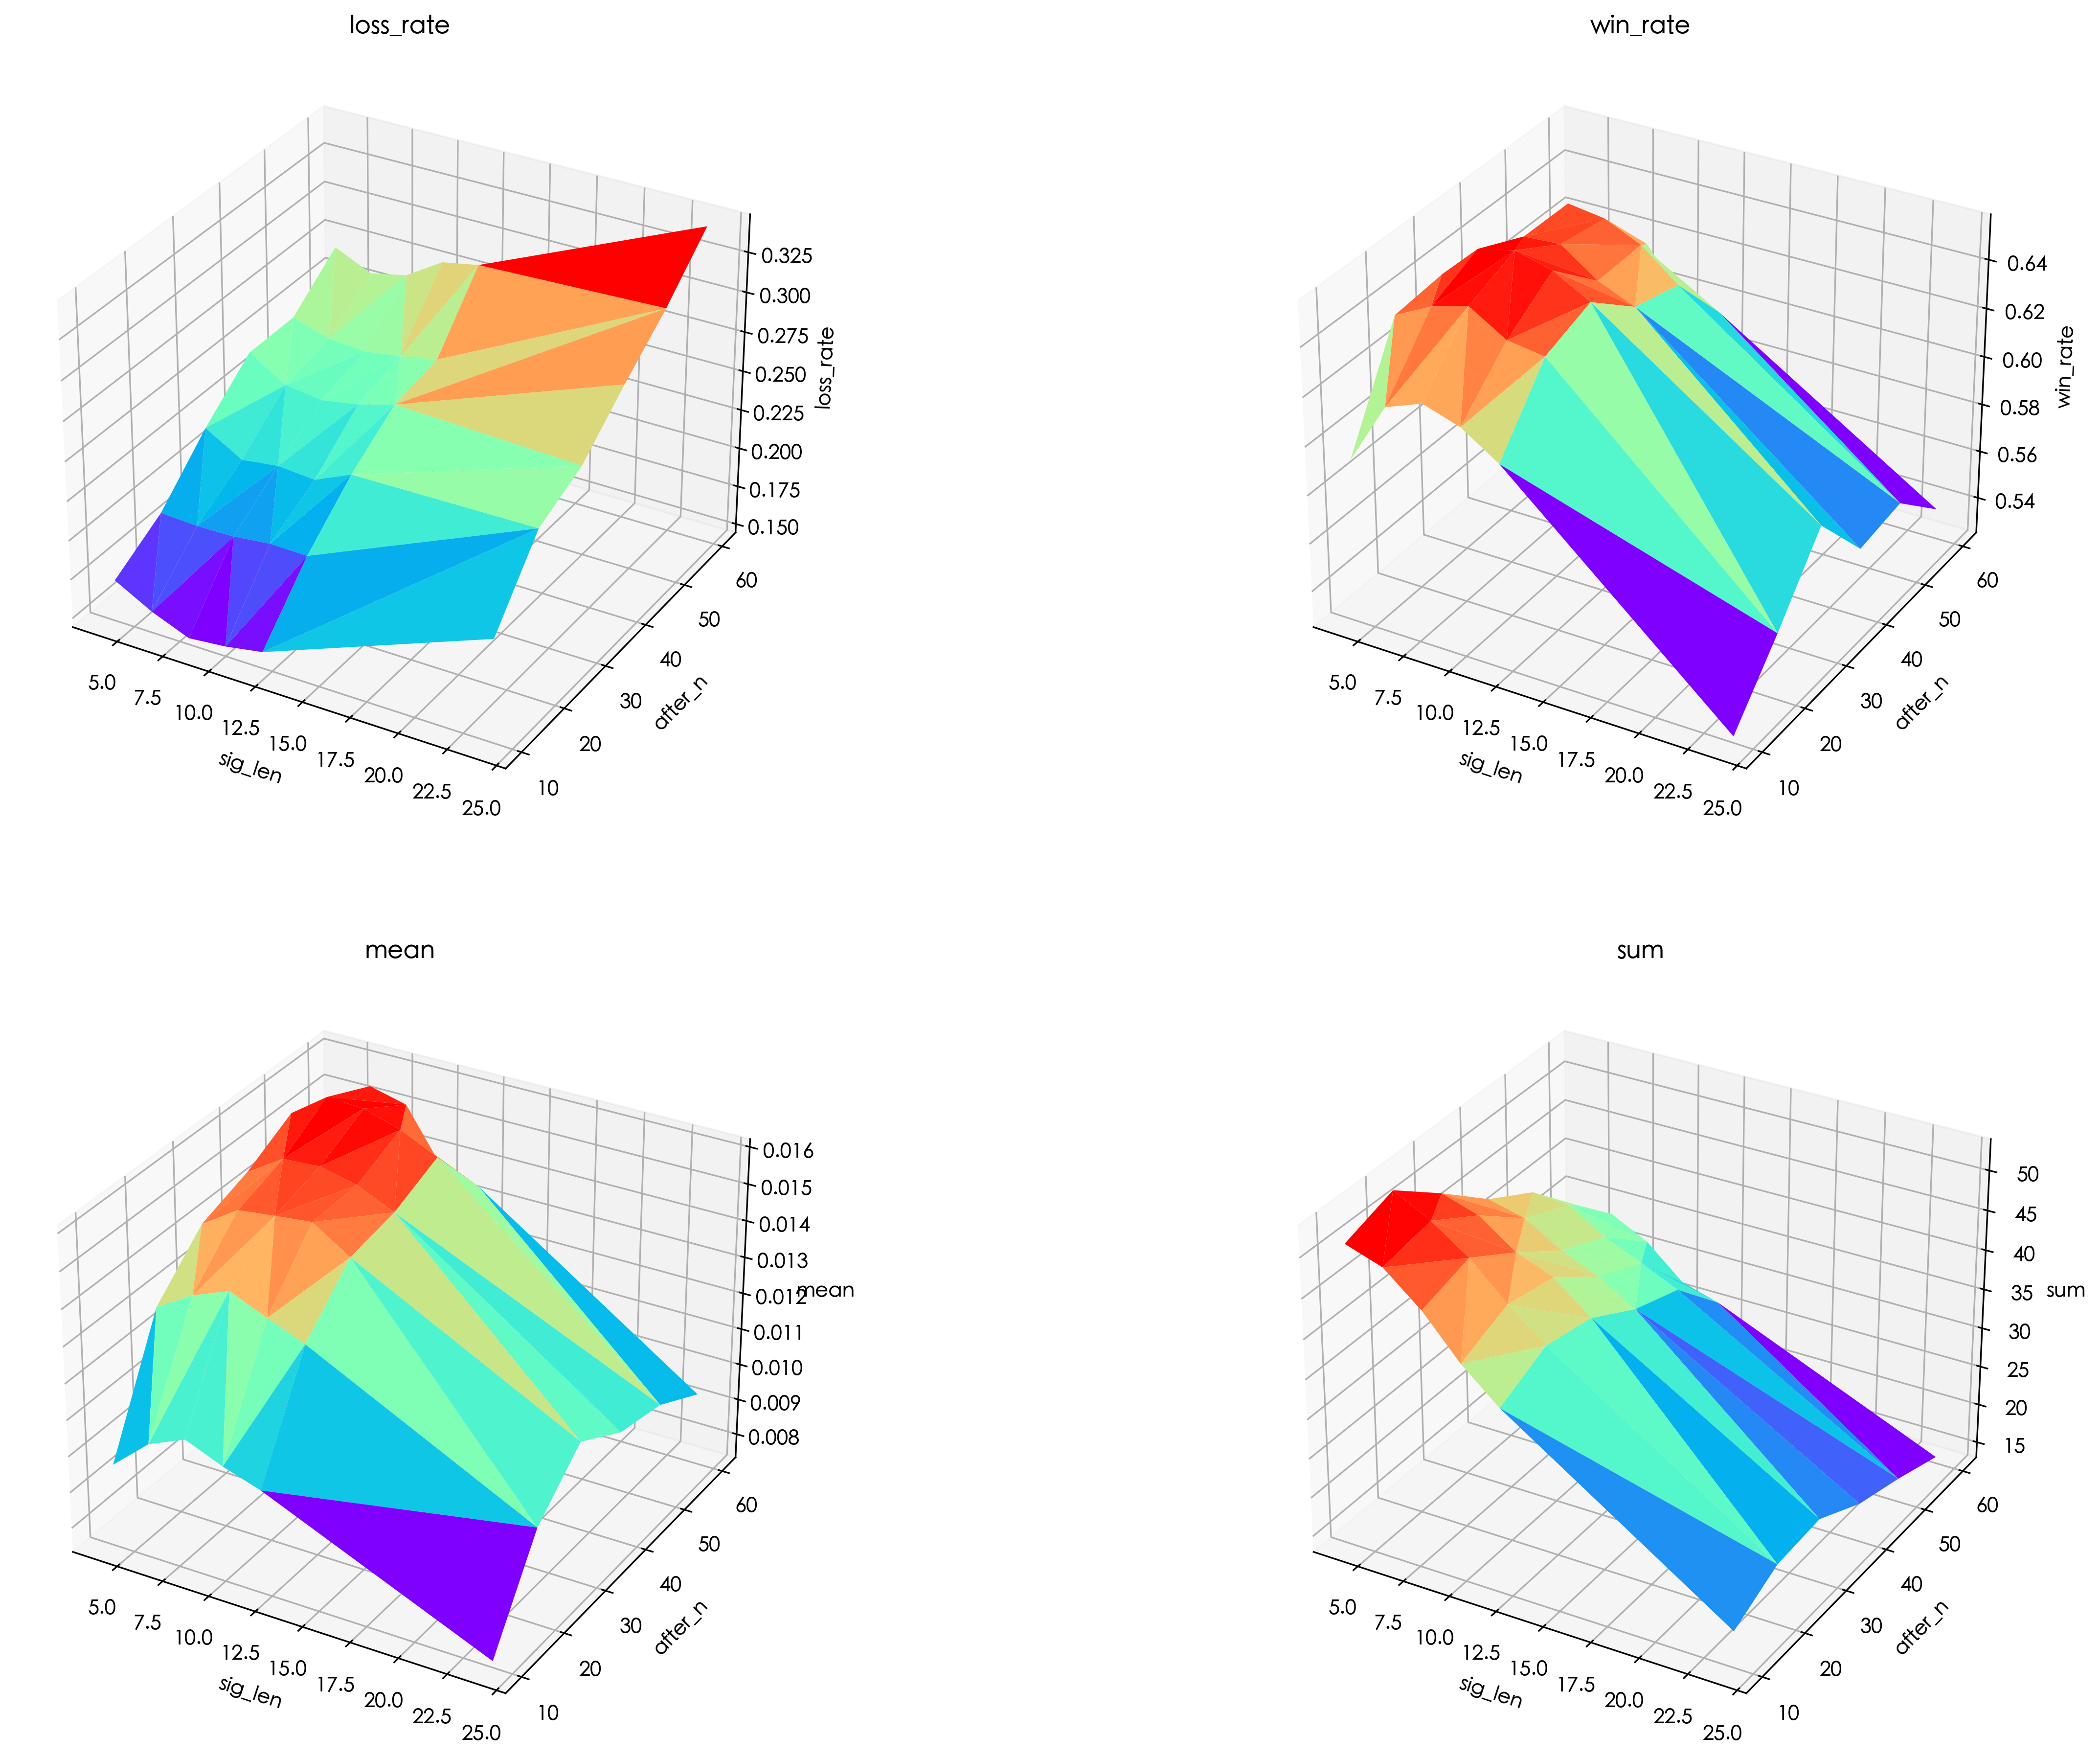

In [71]:
#把三个曲面图都画出来, 且给每个曲面加上标题
fig = plt.figure(figsize=(20, 15), dpi=300)
#标题居中
#fig.suptitle('RSI指标的参数搜索', ha='center')
ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(223, projection='3d')
ax4 = fig.add_subplot(224, projection='3d')

#把三个曲面图的标题分别设置为'loss_rate', 'win_rate', 'mean'
ax1.set_title('loss_rate')
ax2.set_title('win_rate')
ax3.set_title('mean')
ax4.set_title('sum')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.set_xlabel('sig_len')
ax1.set_ylabel('after_n')
ax1.set_zlabel('loss_rate')


#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.set_xlabel('sig_len')
ax2.set_ylabel('after_n')
ax2.set_zlabel('win_rate')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.set_xlabel('sig_len')
ax3.set_ylabel('after_n')
ax3.set_zlabel('mean')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'sum'
ax4.set_xlabel('sig_len')
ax4.set_ylabel('after_n')
ax4.set_zlabel('sum')

stepsig_result['mean'] = stepsig_result['mean'] * -100
stepsig_result['sum'] = stepsig_result['sum'] * -100

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'loss_rate'
ax1.plot_trisurf(stepsig_result['sig_len'], stepsig_result['after_n'], stepsig_result['win_rate'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'win_rate'
ax2.plot_trisurf(stepsig_result['sig_len'], stepsig_result['after_n'], stepsig_result['loss_rate'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'mean'
ax3.plot_trisurf(stepsig_result['sig_len'], stepsig_result['after_n'], stepsig_result['mean'], cmap='rainbow')

#把三个曲面图的x轴, y轴, z轴分别设置为'sig_len', 'after_n', 'sum'
ax4.plot_trisurf(stepsig_result['sig_len'], stepsig_result['after_n'], stepsig_result['sum'], cmap='rainbow')

#plt.subplots_adjust(left = 0.35, right = 0.75, top = 0.8, bottom = 0.3,  wspace=0.1, hspace=0.1)
#让图中间的空白小一点
#plt.subplots_adjust(left = 0.2, right = 0.8, top = 0.9, bottom = 0.1,  wspace=0.1, hspace=0.1)

plt.show()

In [73]:
#找出mean最大的行
print('平均值最大的行')
print(stepsig_result[stepsig_result['mean'] == stepsig_result['mean'].max()])

#找出win_rate最大的行
print('胜率最大的行')
print(stepsig_result[stepsig_result['loss_rate'] == stepsig_result['loss_rate'].max()])

#找出sum最大的行
print('总和最大的行')
print(stepsig_result[stepsig_result['sum'] == stepsig_result['sum'].max()])

平均值最大的行
    sig_len  after_n      mean  win_rate  loss_rate    sum  \
10        6       50  0.016033  0.238076   0.642886  39.33   

    before_filter_number  after_filter_number  Buy_point_number  
10                219667                 2522              2505  
胜率最大的行
    sig_len  after_n      mean  win_rate  loss_rate     sum  \
14        8       30  0.014949  0.209063   0.655681  43.545   

    before_filter_number  after_filter_number  Buy_point_number  
14                219667                 2990              2973  
总和最大的行
   sig_len  after_n      mean  win_rate  loss_rate    sum  \
1        4       20  0.012894  0.189018   0.635811  53.07   

   before_filter_number  after_filter_number  Buy_point_number  
1                219667                 4219              4202  


Text(0.5, 1.0, 'bond 220220 bid ask spread distribution')

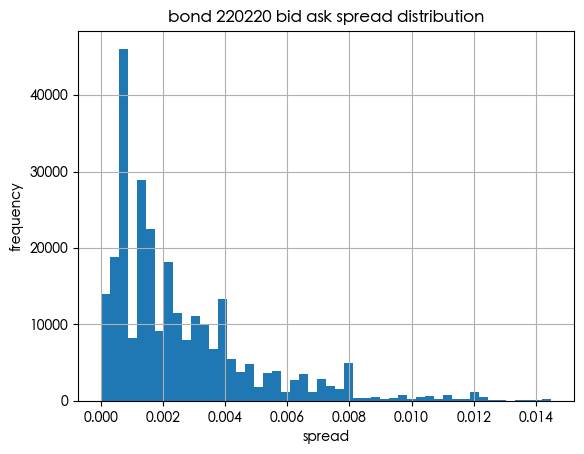

In [105]:
q_low = B220220_df['pspread'].quantile(0.01)
q_high = B220220_df['pspread'].quantile(0.99)
df_filtered = B220220_df['pspread'][(B220220_df['pspread'] >= q_low) & (B220220_df['pspread'] <= q_high)]
df_filtered.hist(bins=50)
#给图标加上坐标轴标签以及标题
plt.xlabel('spread')
plt.ylabel('frequency')
plt.title('bond 220220 bid ask spread distribution')